In [ ]:
# https://k3no.medium.com/how-to-query-in-graphql-6ebb3f7085dc
# https://github.com/sushiswap/sushiswap-subgraph

In [57]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import pandas as pd

mainnet = 'https://api.thegraph.com/subgraphs/name/jiro-ono/sushiswap-exchange'
fantom = 'https://api.thegraph.com/subgraphs/name/sushiswap/fantom-exchange'
matic = 'https://api.thegraph.com/subgraphs/name/sushiswap/matic-exchange'

## Matic

In [78]:
sample_transport=RequestsHTTPTransport(
    url=matic,
    verify=True,
    retries=3,
)

client = Client(transport=sample_transport)

In [79]:
query = gql('''
query {
  factories(where: {liquidityUSD_gt:0}) {
    pairCount
  }
}
''')

response = client.execute(query)
number_of_pairs = int(response['factories'][0]['pairCount'])
print(number_of_pairs)

777


In [80]:
df = pd.DataFrame([])
response_dict = {}
response_list = []


for i in range(number_of_pairs):
    if i % 100 == 0:
        querystring = '''
              query {
              pairs(first: '''+str(100)+' skip: '+str(i)+''' where: {volumeUSD_gt:0}){
                      name
                  }
                }
                '''
        response = client.execute(gql(querystring))
        for row in response['pairs']:
            response_list.append(row['name'])    

df = pd.DataFrame.from_dict(response_list).drop_duplicates()
df[['Token 0', 'Token 1']] = df[0].str.split('-', expand = True, n = 1)
df.value_counts()

0            Token 0  Token 1
$DG-WETH     $DG      WETH       1
WMATIC-FISH  WMATIC   FISH       1
WMATIC-JCT   WMATIC   JCT        1
WMATIC-IRON  WMATIC   IRON       1
WMATIC-INS5  WMATIC   INS5       1
                                ..
USDC-PBNB    USDC     PBNB       1
USDC-PAUTO   USDC     PAUTO      1
USDC-OMEN    USDC     OMEN       1
USDC-NCR     USDC     NCR        1
🌾-WETH       🌾        WETH       1
Length: 388, dtype: int64

In [81]:
interesting_tokens = ['YFI', 'WOOFY', 'CRV', 'ILV', 'WBTC', 'WMATIC', 'MATIC', 'AAVE', 'WETH', 'ETH', 'SUSHI', 'UNI', 'SNX', 'LINK', 'DAI', 'USDC', 'USDT', 'FRAX']
# interesting_tokens = ['USDC', 'USDT', 'DAI', 'FRAX', 'IRON']
# interesting_tokens = ['MATIC', 'DAI', 'USDC', 'USDT', 'WBTC', 'WETH', 'WMATIC']

criteria = df['Token 0'].isin(interesting_tokens) & \
           df['Token 1'].isin(interesting_tokens)

df_filtered = df.loc[criteria,:]
df_filtered.columns = ['Pair', 'Token 0', 'Token 1']
df_filtered.head()

,Pair,Token 0,Token 1
18,SNX-WETH,SNX,WETH
20,WMATIC-CRV,WMATIC,CRV
26,SUSHI-DAI,SUSHI,DAI
39,UNI-USDT,UNI,USDT
43,WMATIC-WOOFY,WMATIC,WOOFY


In [82]:
# make a list of strings with double quotes

stringtest = "["

for i in df_filtered['Pair'].values.tolist():
    stringtest += '"'+ i + '",'
    
stringtest[:-1]+"]"

'["SNX-WETH","WMATIC-CRV","SUSHI-DAI","UNI-USDT","WMATIC-WOOFY","FRAX-USDT","WETH-AAVE","USDC-WETH","CRV-WETH","DAI-USDT","SUSHI-WBTC","USDC-AAVE","WMATIC-SNX","WETH-WOOFY","USDC-USDT","USDC-SNX","WMATIC-USDT","SUSHI-WMATIC","WMATIC-LINK","WETH-DAI","WMATIC-FRAX","LINK-WETH","WMATIC-AAVE","WMATIC-UNI","WMATIC-WBTC","WMATIC-DAI","USDC-LINK","CRV-USDC","FRAX-USDC","USDT-AAVE","SUSHI-WETH","LINK-DAI","WBTC-AAVE","WETH-USDT","WMATIC-YFI","WMATIC-WETH","WETH-UNI","WMATIC-USDC","USDC-DAI","WBTC-USDC","DAI-AAVE","WETH-YFI","SUSHI-USDC","WBTC-WETH","SUSHI-USDT"]'

In [83]:
querystring = '''
              query {
  pairs(where: {name_in: ''' + stringtest[:-1]+"]" + '''}){
    name
    dayData{
      date
      reserveUSD
      volumeUSD
      txCount
    }
  }
}
                '''
response = client.execute(gql(querystring))
response

{'pairs': [{'dayData': [{'date': 1621296000,
     'reserveUSD': '2134.040263710702641917271382309285',
     'txCount': '11',
     'volumeUSD': '612.6849219683397147376470863620611'},
    {'date': 1621382400,
     'reserveUSD': '5095343.794480396319059345248991458',
     'txCount': '1046',
     'volumeUSD': '2353509.179360423566738388574263848'},
    {'date': 1621468800,
     'reserveUSD': '8463147.210895523987001164897695253',
     'txCount': '255',
     'volumeUSD': '613719.6151607147548550266710408844'},
    {'date': 1621555200,
     'reserveUSD': '9128434.710236544022353138801699636',
     'txCount': '218',
     'volumeUSD': '968980.6519168736313512314844739305'},
    {'date': 1621641600,
     'reserveUSD': '8811008.909905263086234836307299904',
     'txCount': '179',
     'volumeUSD': '796978.7937894434241363937829997433'},
    {'date': 1621728000,
     'reserveUSD': '7042581.616448778504439094289549729',
     'txCount': '175',
     'volumeUSD': '435016.4777905333476112728197813453

In [84]:
df4 = pd.DataFrame([])

for pair_no in range(len(response['pairs'])):
    df3 = pd.DataFrame.from_dict(response['pairs'][pair_no])
    df3[['date', 'reserveUSD', 'txCount', 'volumeUSD']] = df3['dayData'].apply(pd.Series)
    df3 = df3.drop(columns = ['dayData'])
    df4 = df4.append(df3)
    
df4[['date','reserveUSD','volumeUSD']] = df4[['date','reserveUSD','volumeUSD']].astype(float)
df4['txCount'] = df4['txCount'].astype(int)
df4['date'] = pd.to_datetime(df4['date'], unit='s')
df4['fee'] = round(df4['volumeUSD'] * 0.003,6)
df4['1y APR for 100 invested'] = round((100/df4['reserveUSD']) * df4['fee'] * 365,3)
df4['name'] = '[Matic] ' + df4['name']
df4.head(1)

,name,date,reserveUSD,txCount,volumeUSD,fee,1y APR for 100 invested
0,[Matic] SNX-WETH,2021-05-18,2134.040264,11,612.684922,1.838055,31.438


In [85]:
latest_results = df4.drop_duplicates(subset = ['name'], keep = 'last')\
                    .sort_values(by = '1y APR for 100 invested',
                                 ascending = False)\
                    .reset_index(drop = True)
latest_results.style.format({'reserveUSD': "{:0<4,.2f}"})

,name,date,reserveUSD,txCount,volumeUSD,fee,1y APR for 100 invested
0,[Matic] WBTC-AAVE,2021-06-07 00:00:00,0.00,4,1.416281,0.004249,226893.087000
1,[Matic] WETH-WOOFY,2021-06-03 00:00:00,0.01,3,28.149906,0.084450,218792.699000
2,[Matic] FRAX-USDT,2021-06-09 00:00:00,0.03,11,10.816569,0.032450,41700.428000
3,[Matic] WMATIC-USDC,2021-06-11 00:00:00,"19,897,203.69",29164,59686302.314898,179058.906945,328.471000
4,[Matic] WMATIC-USDT,2021-06-13 00:00:00,"2,609.10",1492,6829.423462,20.488270,286.621000
5,[Matic] WMATIC-WETH,2021-06-09 00:00:00,"107,111,717.56",15652,49749848.734405,149249.546203,50.859000
6,[Matic] SUSHI-USDC,2021-06-13 00:00:00,"16,131.63",390,6639.315992,19.917948,45.067000
7,[Matic] SUSHI-WMATIC,2021-06-13 00:00:00,"247,811.91",3299,101350.362333,304.051087,44.783000
8,[Matic] WMATIC-SNX,2021-06-02 00:00:00,0.00,3,0.001646,0.000005,43.892000
9,[Matic] WMATIC-DAI,2021-06-13 00:00:00,"1,630.47",464,544.584123,1.633752,36.574000


In [87]:
df_horizontal = df4.pivot(index = 'name',
                          columns = 'date',
                          values = '1y APR for 100 invested')
# .style.format("{:0<4,.2f}")

# drop last day as it is incomplete
df_horizontal = df_horizontal.drop(columns = df_horizontal.columns[-1])
df_horizontal


df_horizontal['Median APR last 3 days'] = df_horizontal[df_horizontal.columns[-3:]].median(axis = 1)
df_horizontal['Median APR last 7 days'] = df_horizontal[df_horizontal.columns[-7:]].median(axis = 1)
df_horizontal['Median APR last 14 days'] = df_horizontal[df_horizontal.columns[-14:]].median(axis = 1)
df_horizontal[['Median APR last 3 days', 'Median APR last 7 days', 'Median APR last 14 days']]\
.sort_values(by = 'Median APR last 3 days', ascending = False)

date,Median APR last 3 days,Median APR last 7 days,Median APR last 14 days
name,,,
[Matic] WMATIC-USDC,244.5550,332.00100,244.555000
[Matic] WMATIC-LINK,221.7040,275.42900,896.508500
[Matic] WMATIC-USDT,87.5140,202.93200,186.828000
[Matic] WMATIC-FRAX,76.5800,155.37200,132.131000
[Matic] WMATIC-DAI,53.5070,53.50700,39.555000
[Matic] WMATIC-WBTC,47.2160,47.21600,47.216000
[Matic] SUSHI-WMATIC,43.3290,53.55200,53.552000
[Matic] SUSHI-USDC,35.6680,35.88500,38.701000
[Matic] SUSHI-WETH,23.3350,23.78000,32.052000


## Fantom

In [90]:
sample_transport=RequestsHTTPTransport(
    url=fantom,
    verify=True,
    retries=3,
)

client = Client(transport=sample_transport)

query = gql('''
query {
  factories(where: {liquidityUSD_gt:0}) {
    pairCount
  }
}
''')

response = client.execute(query)
number_of_pairs = int(response['factories'][0]['pairCount'])
print(number_of_pairs)



response_list = []

for i in range(number_of_pairs):
    if i % 100 == 0:
        querystring = '''
              query {
              pairs(first: '''+str(100)+' skip: '+str(i)+''' where: {volumeUSD_gt:0}){
                      name
                  }
                }
                '''
        response = client.execute(gql(querystring))
        for row in response['pairs']:
            response_list.append(row['name'])    

df_fantom = pd.DataFrame.from_dict(response_list).drop_duplicates()
df_fantom[['Token 0', 'Token 1']] = df_fantom[0].str.split('-', expand = True, n = 1)
df_fantom.value_counts()

criteria = df_fantom['Token 0'].isin(interesting_tokens) & \
           df_fantom['Token 1'].isin(interesting_tokens)

df_fantom_filtered = df_fantom.loc[criteria,:]
df_fantom_filtered.columns = ['Pair', 'Token 0', 'Token 1']

# make a list of strings with double quotes
stringtest = "["

for i in df_filtered['Pair'].values.tolist():
    stringtest += '"'+ i + '",'

# find the daily returns
querystring = '''
              query {
  pairs(where: {name_in: ''' + stringtest[:-1]+"]" + '''}){
    name
    dayData{
      date
      reserveUSD
      volumeUSD
      txCount
    }
  }
}
                '''
response = client.execute(gql(querystring))


# turn the daily returns into a dataframe
df4_fantom = pd.DataFrame([])

for pair_no in range(len(response['pairs'])):
    df3_fantom = pd.DataFrame.from_dict(response['pairs'][pair_no])
    df3_fantom[['date', 'reserveUSD', 'txCount', 'volumeUSD']] = df3_fantom['dayData'].apply(pd.Series)
    df3_fantom = df3_fantom.drop(columns = ['dayData'])
    df4_fantom = df4_fantom.append(df3_fantom)
    
df4_fantom[['date','reserveUSD','volumeUSD']] = df4_fantom[['date','reserveUSD','volumeUSD']].astype(float)
df4_fantom['txCount'] = df4_fantom['txCount'].astype(int)
df4_fantom['date'] = pd.to_datetime(df4_fantom['date'], unit='s')
df4_fantom['fee'] = round(df4_fantom['volumeUSD'] * 0.003,6)
df4_fantom['1y APR for 100 invested'] = round((100/df4_fantom['reserveUSD']) * df4_fantom['fee'] * 365,3)
df4_fantom['name'] = '[Fantom] ' + df4_fantom['name']


df_horizontal_fantom = df4_fantom.pivot(index = 'name',
                          columns = 'date',
                          values = '1y APR for 100 invested')
# .style.format("{:0<4,.2f}")

# drop last day as it is incomplete
df_horizontal_fantom = df_horizontal_fantom.drop(columns = df_horizontal_fantom.columns[-1])
df_horizontal_fantom


df_horizontal_fantom['Median APR last 3 days'] = df_horizontal_fantom[df_horizontal_fantom.columns[-3:]].median(axis = 1)
df_horizontal_fantom['Median APR last 7 days'] = df_horizontal_fantom[df_horizontal_fantom.columns[-7:]].median(axis = 1)
df_horizontal_fantom['Median APR last 14 days'] = df_horizontal_fantom[df_horizontal_fantom.columns[-14:]].median(axis = 1)
df_horizontal_fantom[['Median APR last 3 days', 'Median APR last 7 days', 'Median APR last 14 days']]\
.sort_values(by = 'Median APR last 3 days', ascending = False)

616


date,Median APR last 3 days,Median APR last 7 days,Median APR last 14 days
name,,,
[Fantom] USDC-AAVE,12.320,12.320,12.3200
[Fantom] USDC-DAI,3.711,3.711,2.9535


In [92]:
df_horizontal.append(df_horizontal_fantom)[['Median APR last 3 days', 'Median APR last 7 days', 'Median APR last 14 days']]\
.sort_values(by = 'Median APR last 3 days', ascending = False)

date,Median APR last 3 days,Median APR last 7 days,Median APR last 14 days
name,,,
[Matic] WMATIC-USDC,244.5550,332.00100,244.555000
[Matic] WMATIC-LINK,221.7040,275.42900,896.508500
[Matic] WMATIC-USDT,87.5140,202.93200,186.828000
[Matic] WMATIC-FRAX,76.5800,155.37200,132.131000
[Matic] WMATIC-DAI,53.5070,53.50700,39.555000
[Matic] WMATIC-WBTC,47.2160,47.21600,47.216000
[Matic] SUSHI-WMATIC,43.3290,53.55200,53.552000
[Matic] SUSHI-USDC,35.6680,35.88500,38.701000
[Matic] SUSHI-WETH,23.3350,23.78000,32.052000


In [94]:
print(df_horizontal.append(df_horizontal_fantom)[['Median APR last 3 days', 'Median APR last 7 days', 'Median APR last 14 days']]\
.sort_values(by = 'Median APR last 3 days', ascending = False).to_string())

date                  Median APR last 3 days  Median APR last 7 days  Median APR last 14 days
name                                                                                         
[Matic] WMATIC-USDC                 244.5550               332.00100               244.555000
[Matic] WMATIC-LINK                 221.7040               275.42900               896.508500
[Matic] WMATIC-USDT                  87.5140               202.93200               186.828000
[Matic] WMATIC-FRAX                  76.5800               155.37200               132.131000
[Matic] WMATIC-DAI                   53.5070                53.50700                39.555000
[Matic] WMATIC-WBTC                  47.2160                47.21600                47.216000
[Matic] SUSHI-WMATIC                 43.3290                53.55200                53.552000
[Matic] SUSHI-USDC                   35.6680                35.88500                38.701000
[Matic] SUSHI-WETH                   23.3350                

c:\users\mn850\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


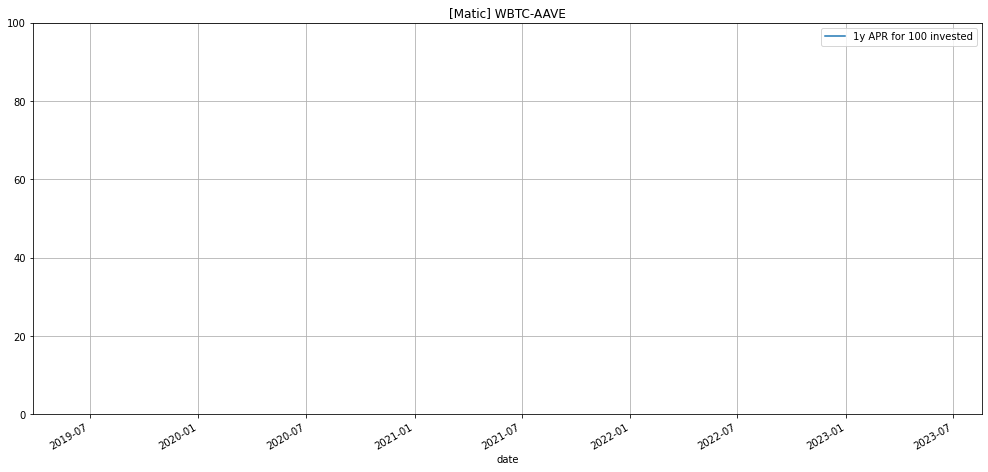

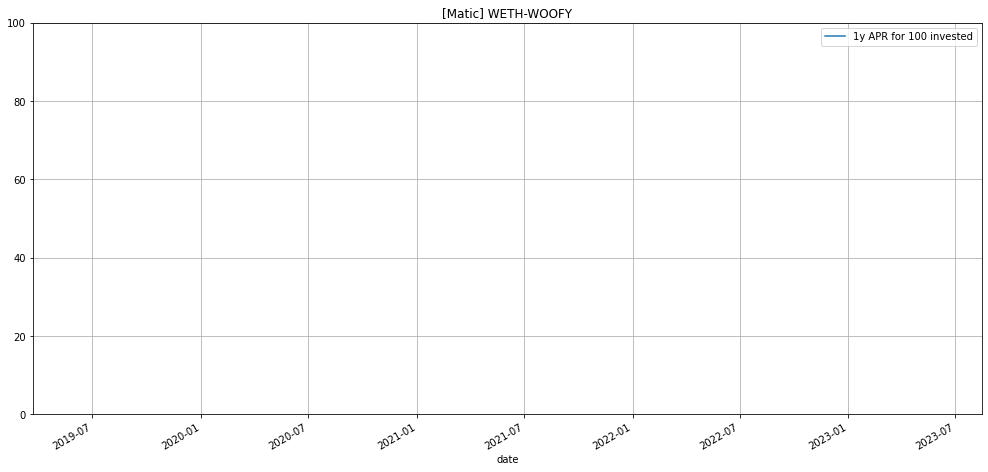

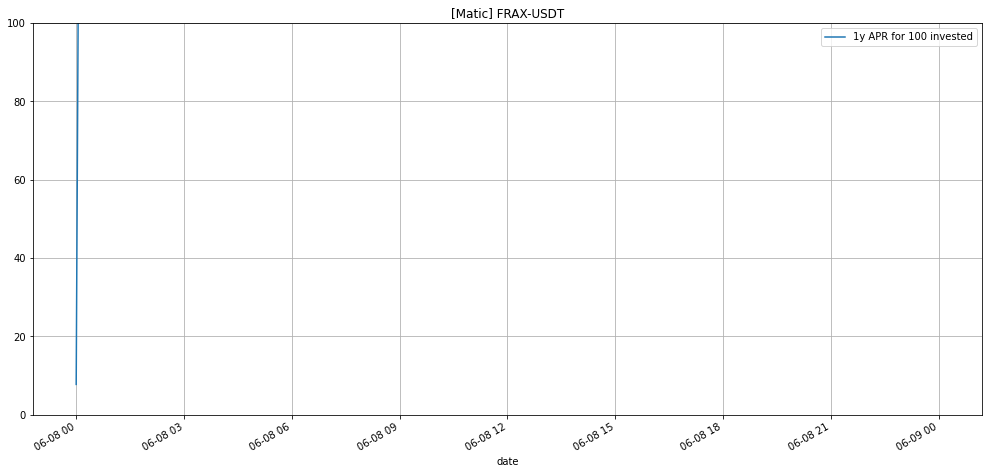

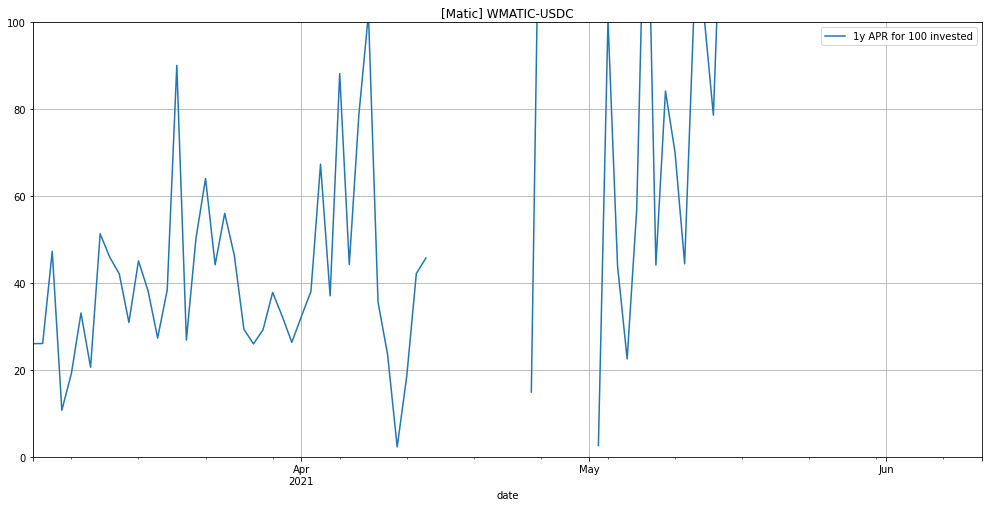

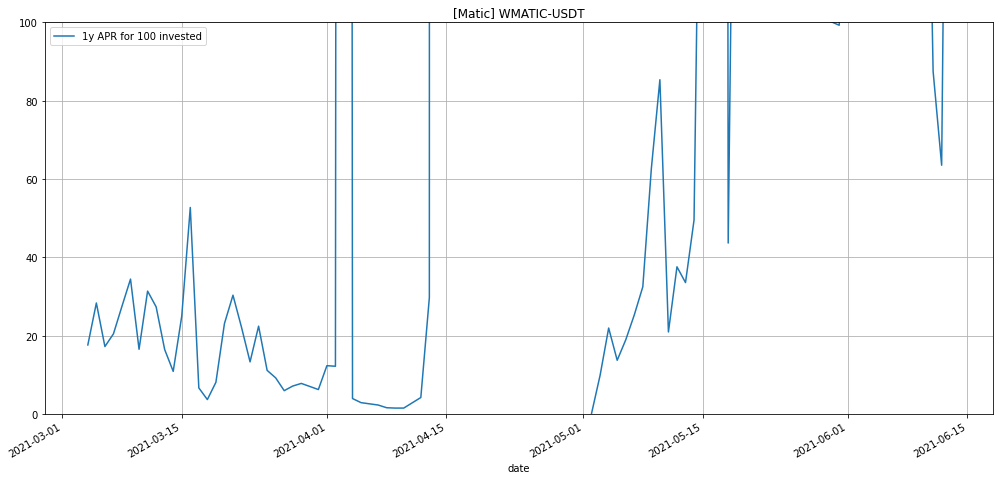

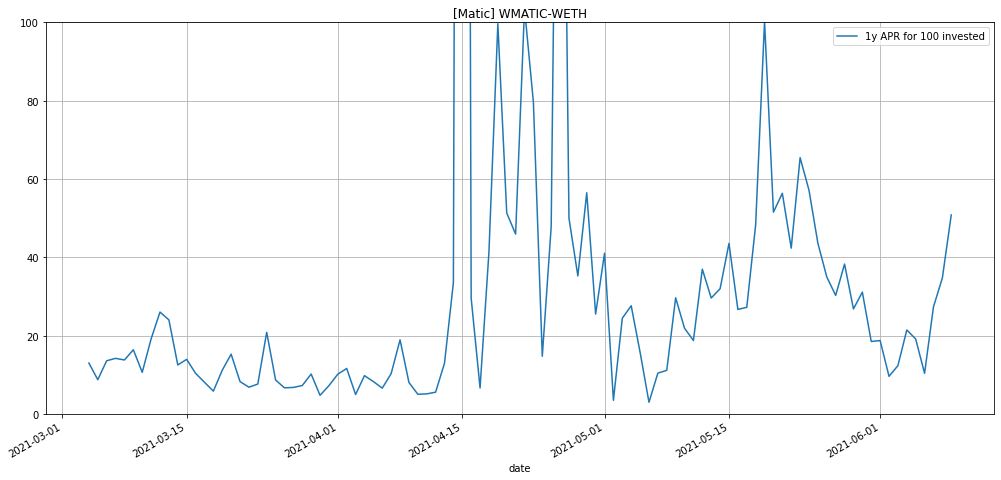

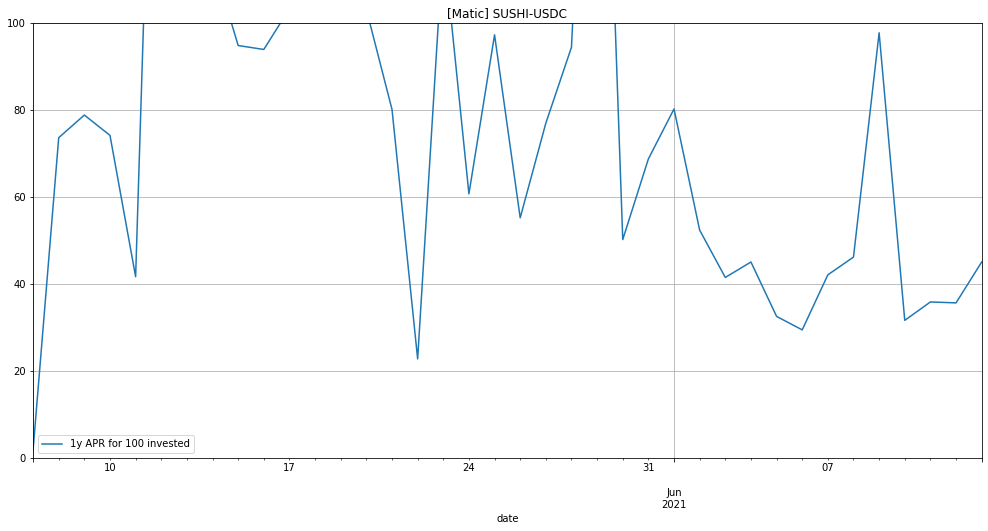

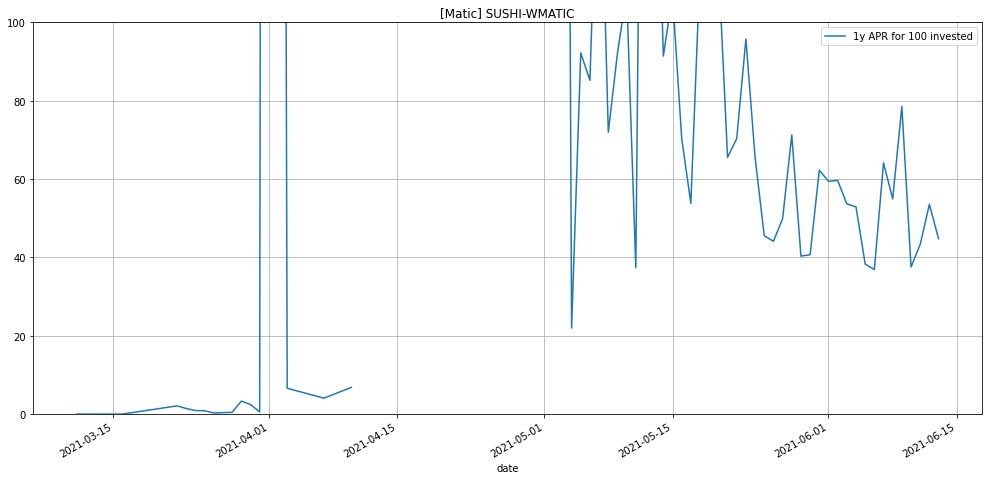

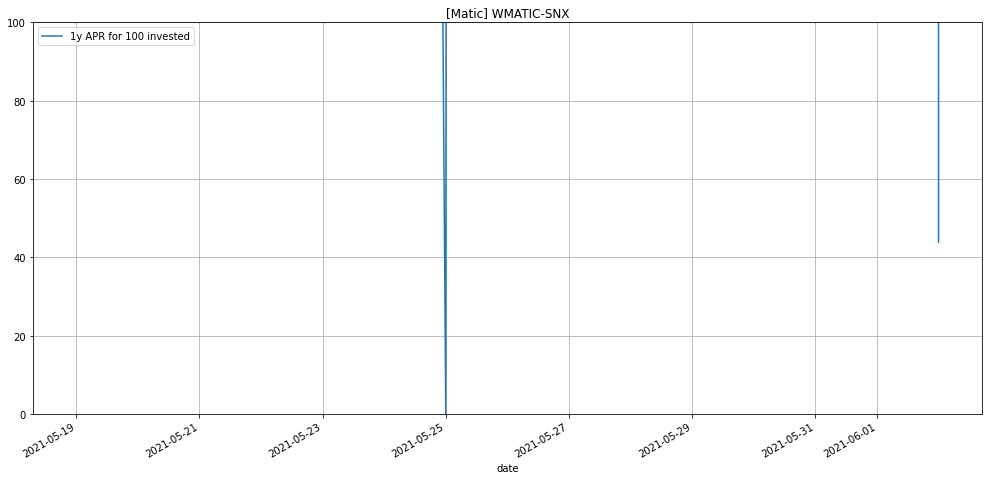

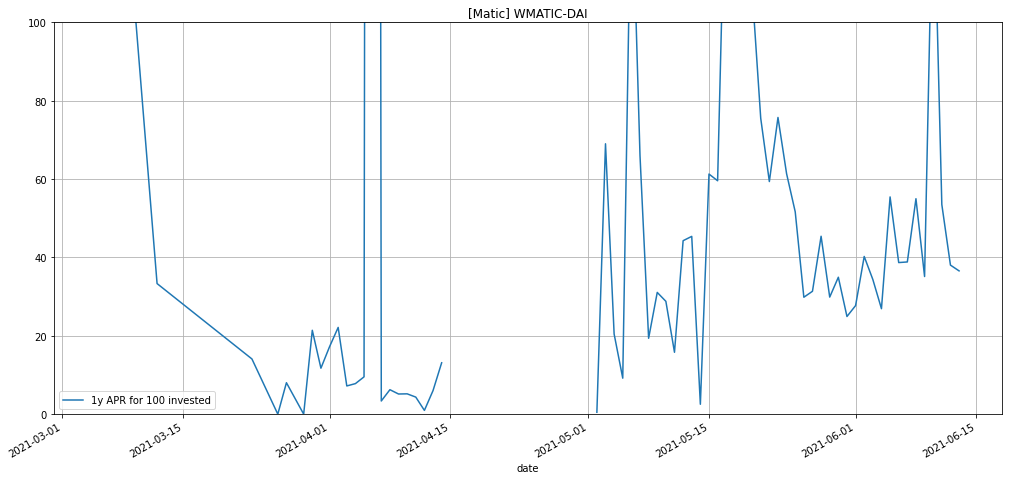

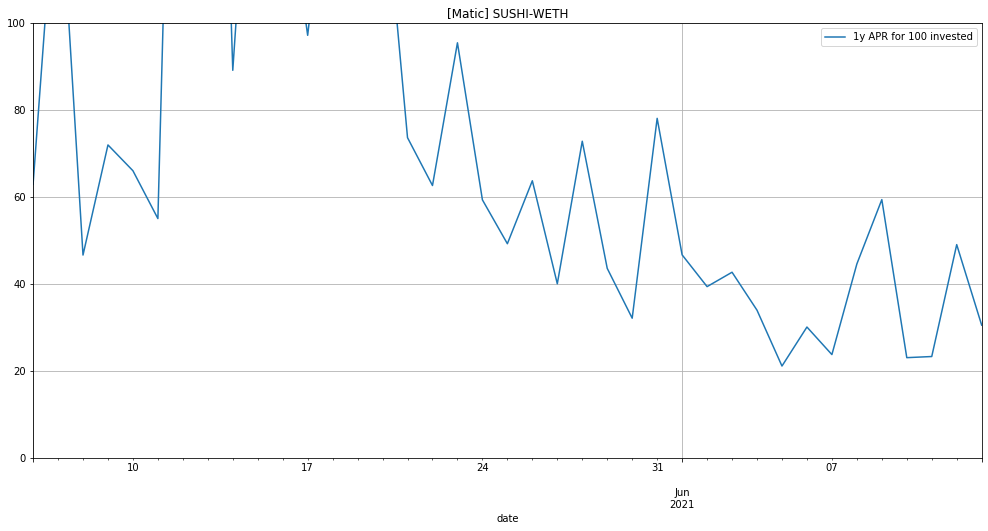

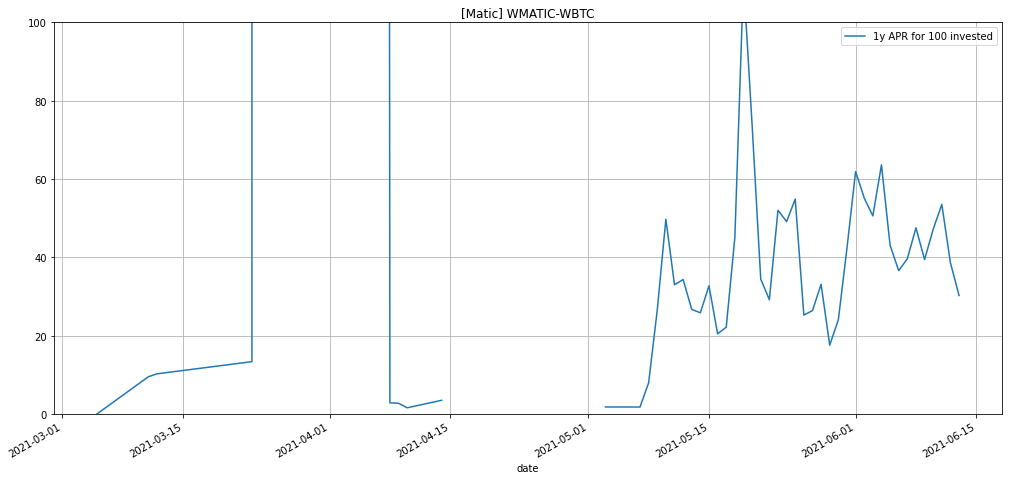

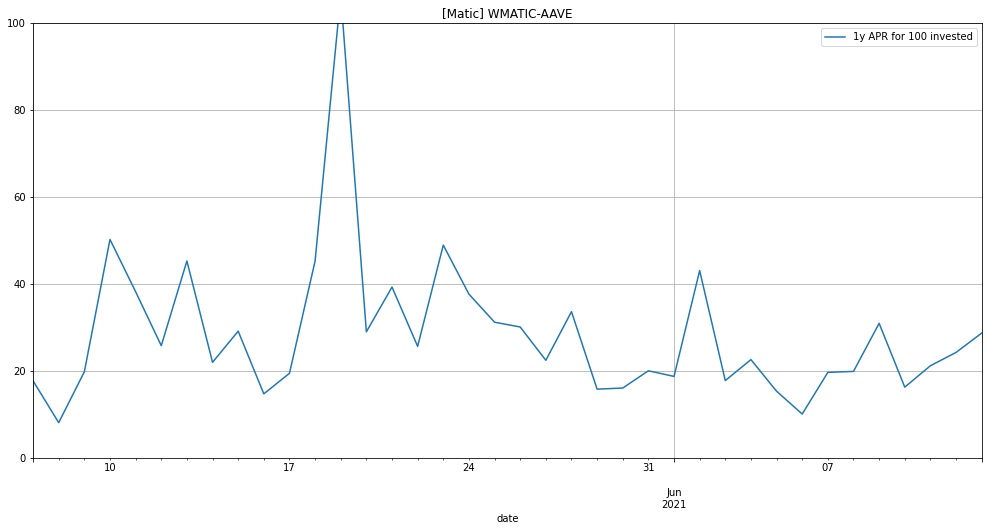

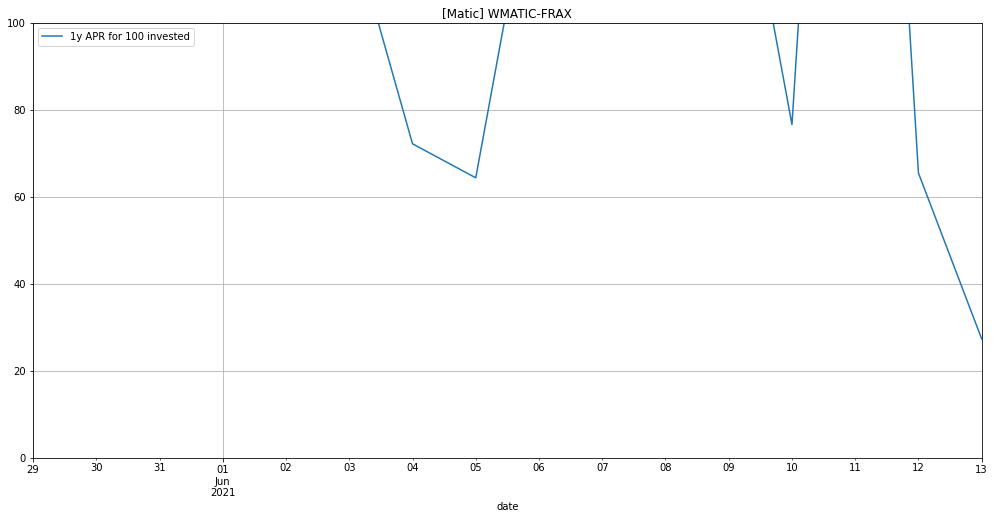

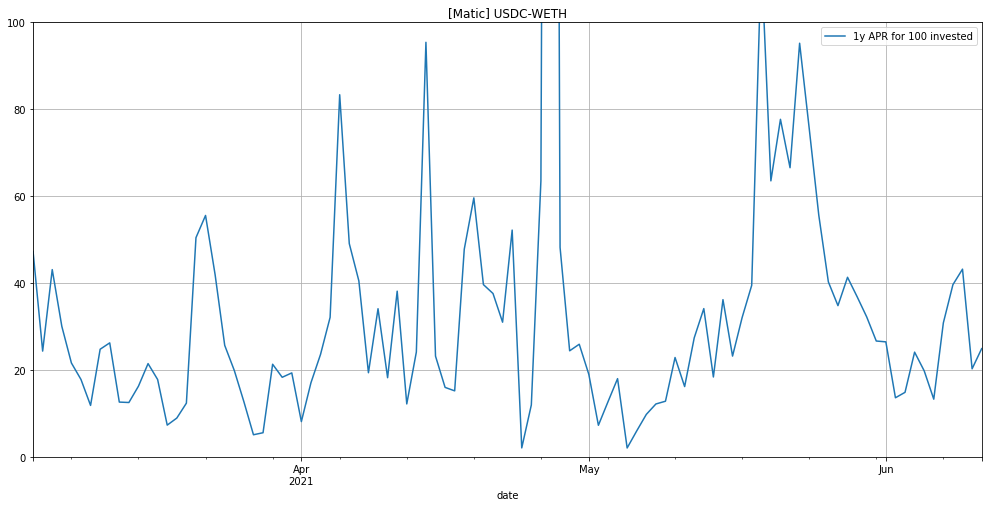

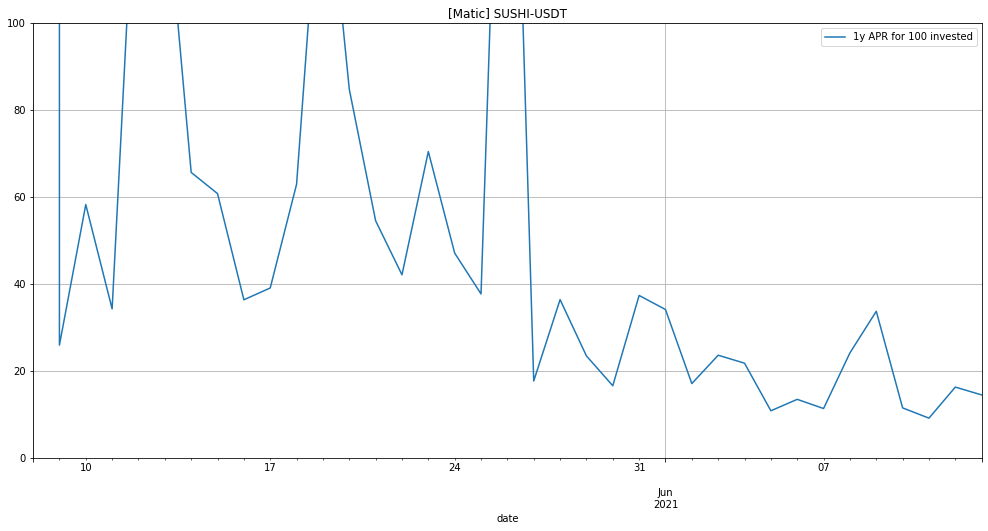

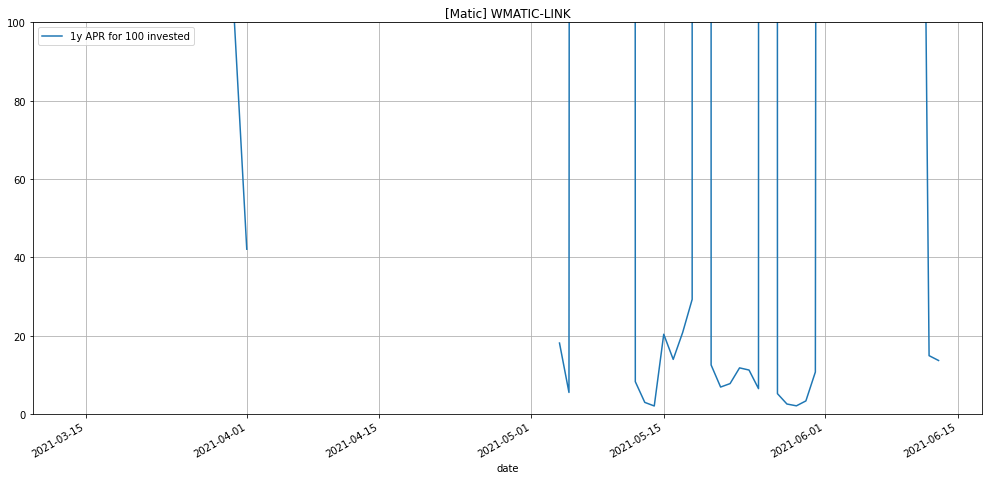

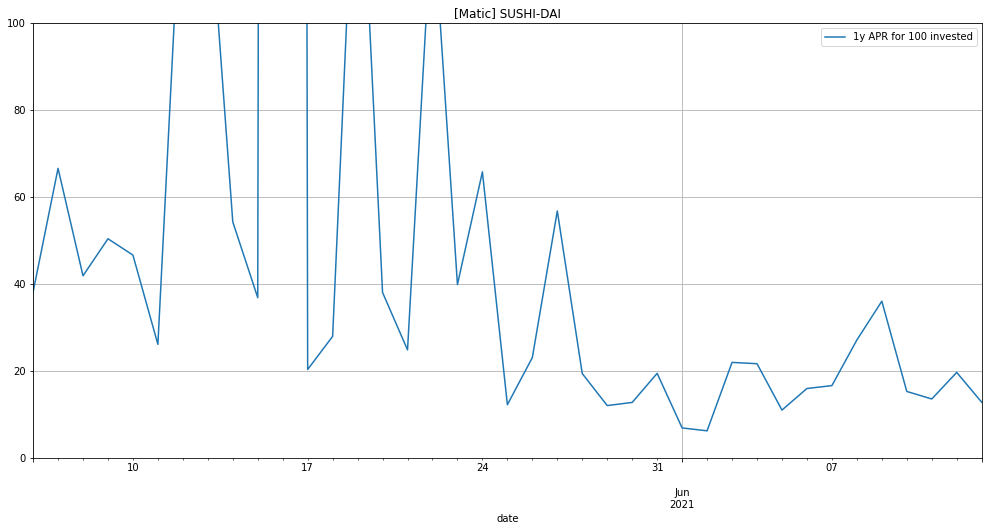

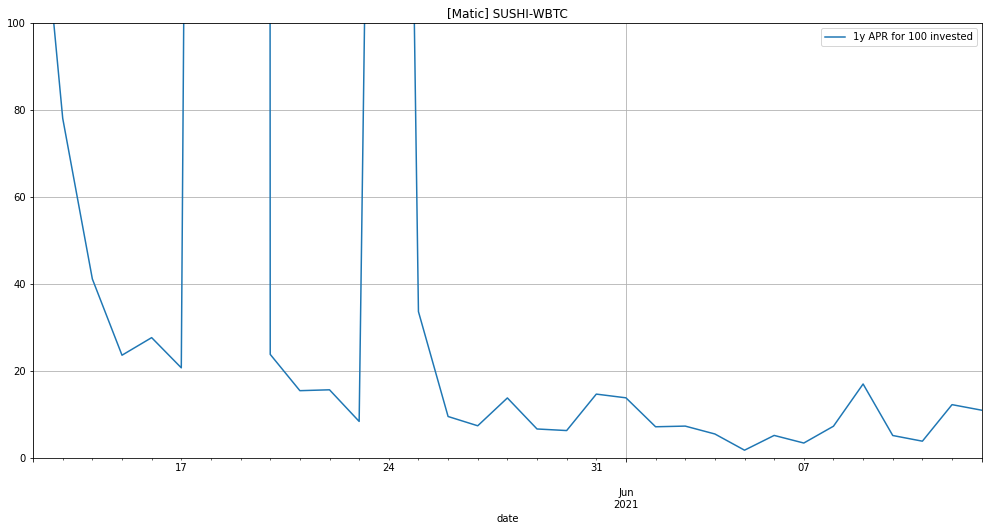

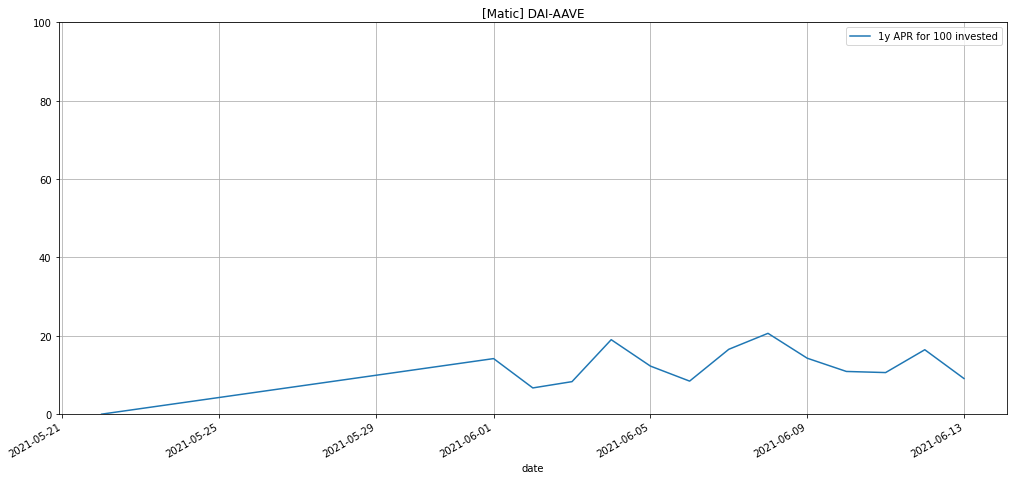

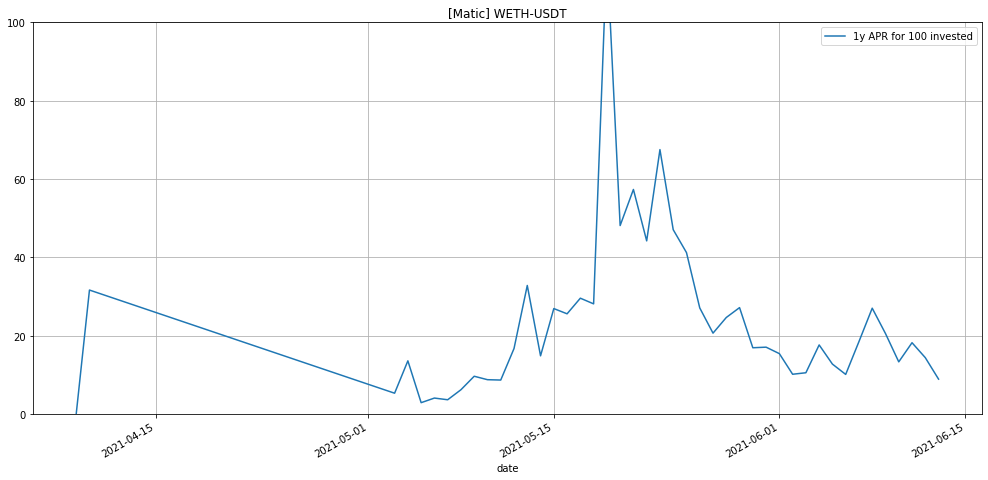

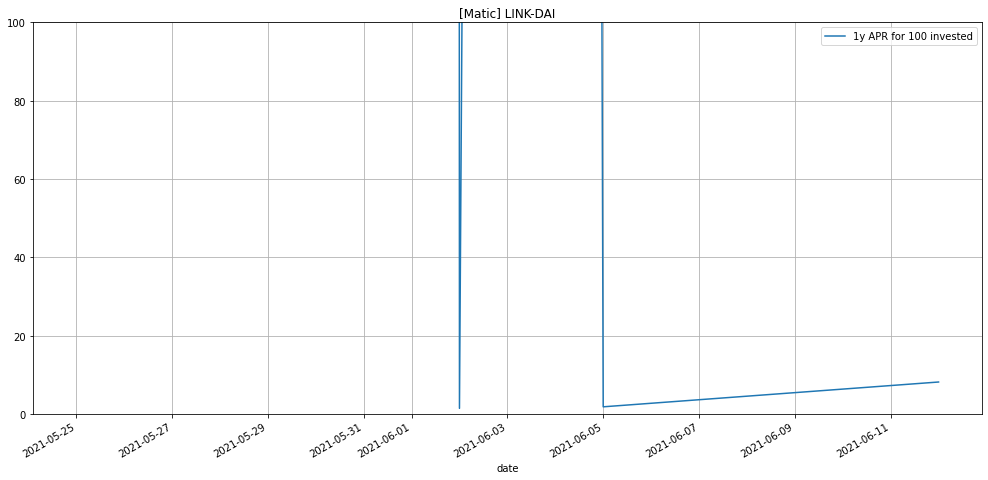

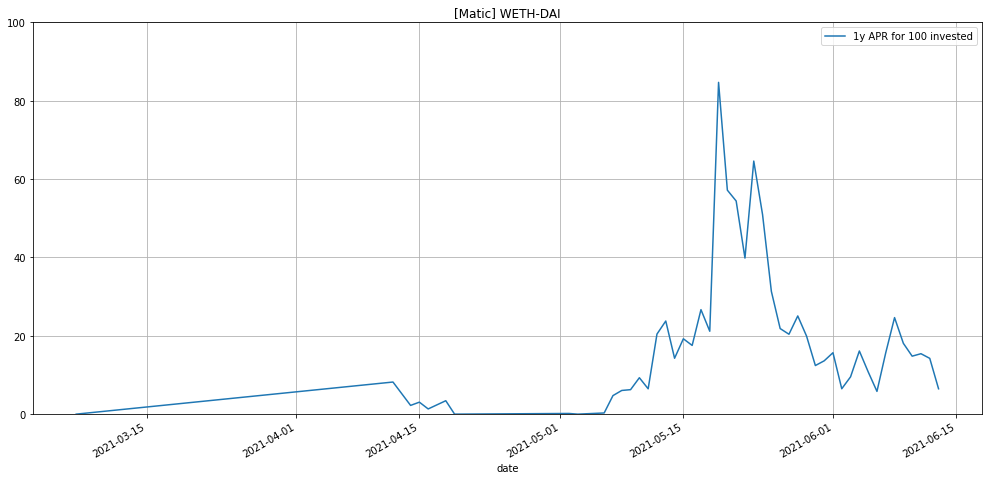

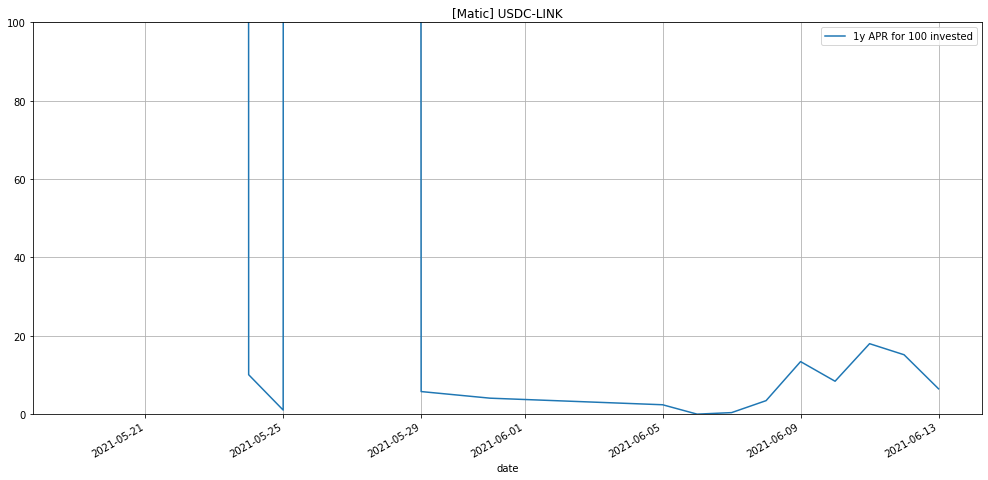

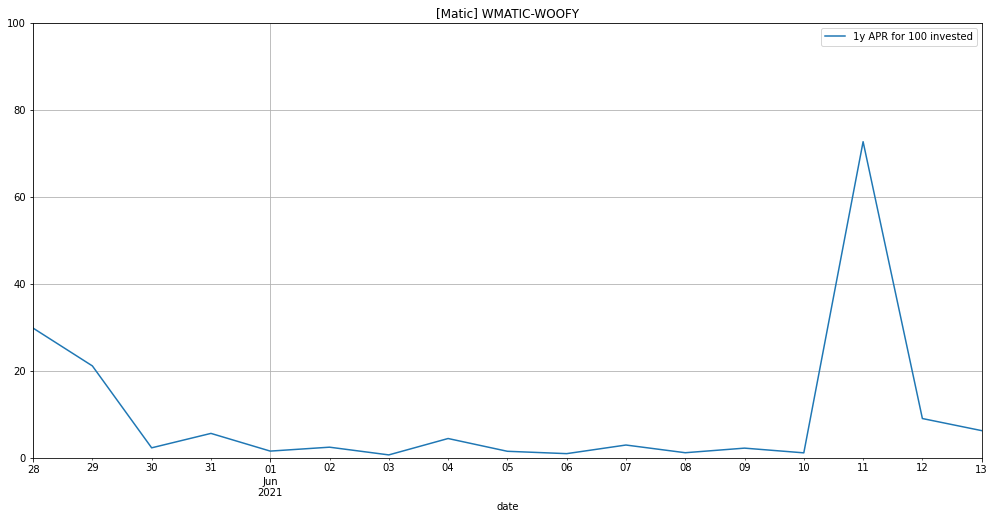

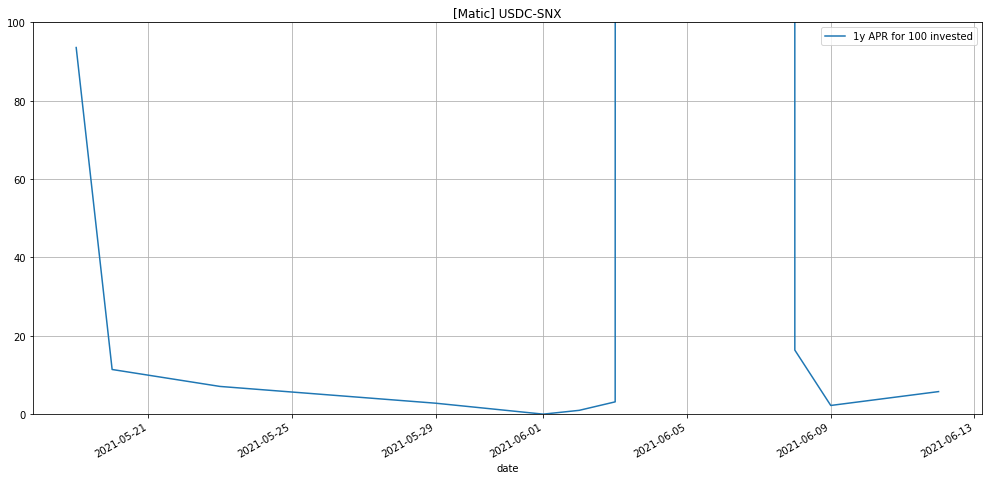

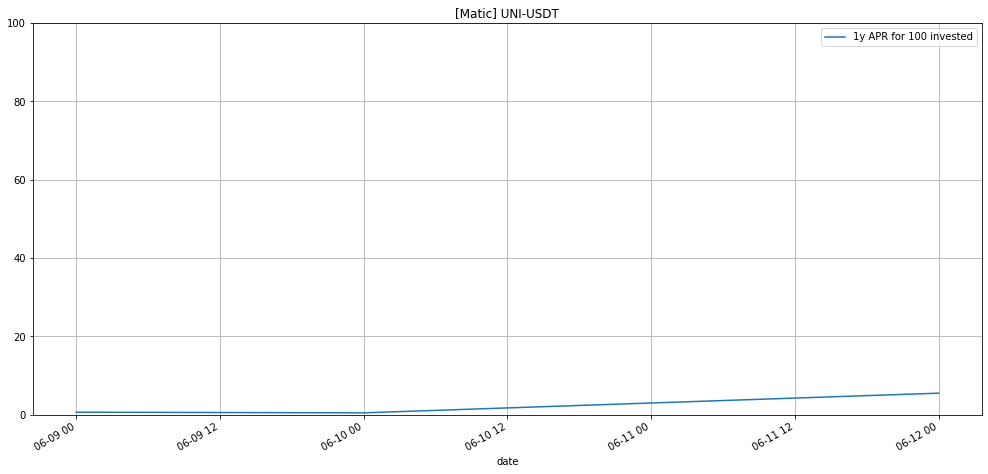

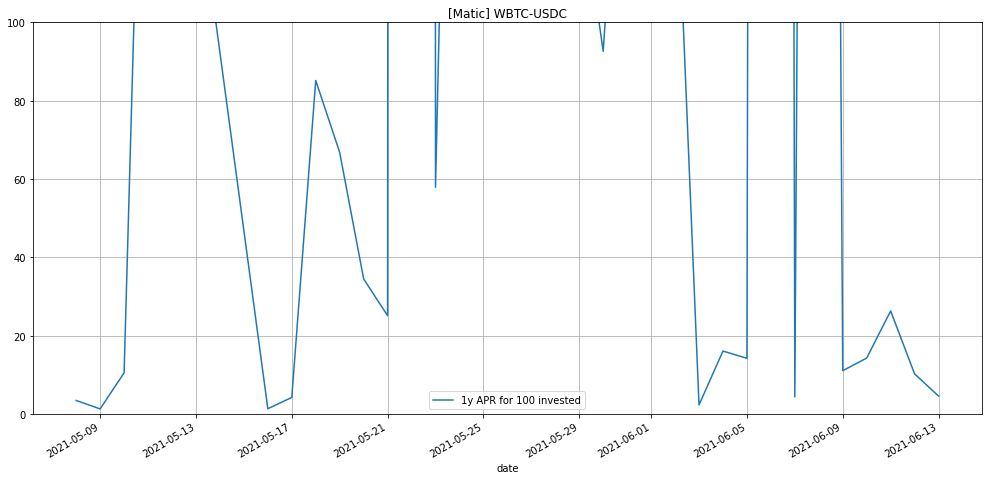

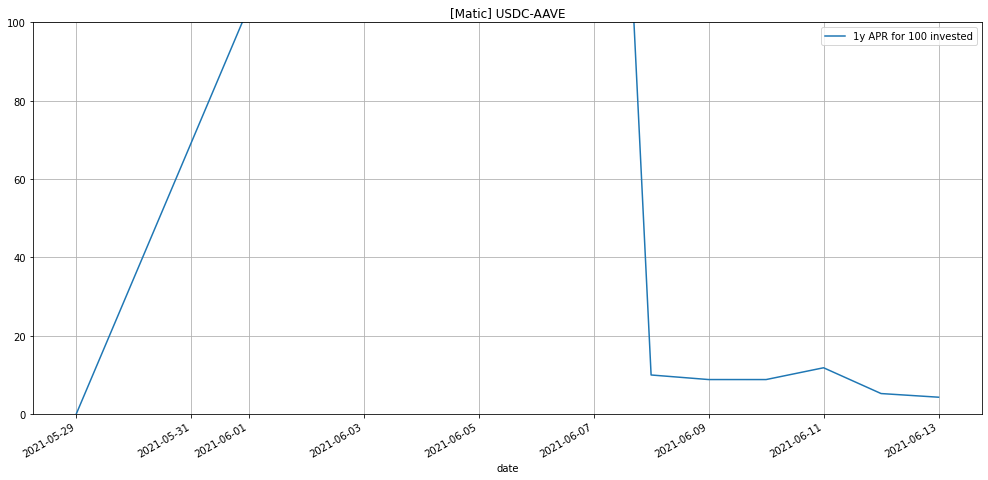

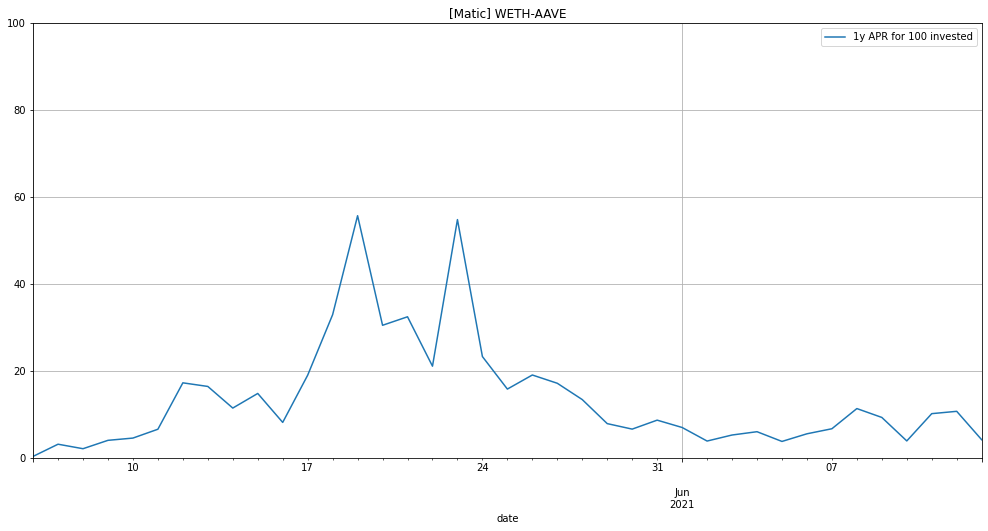

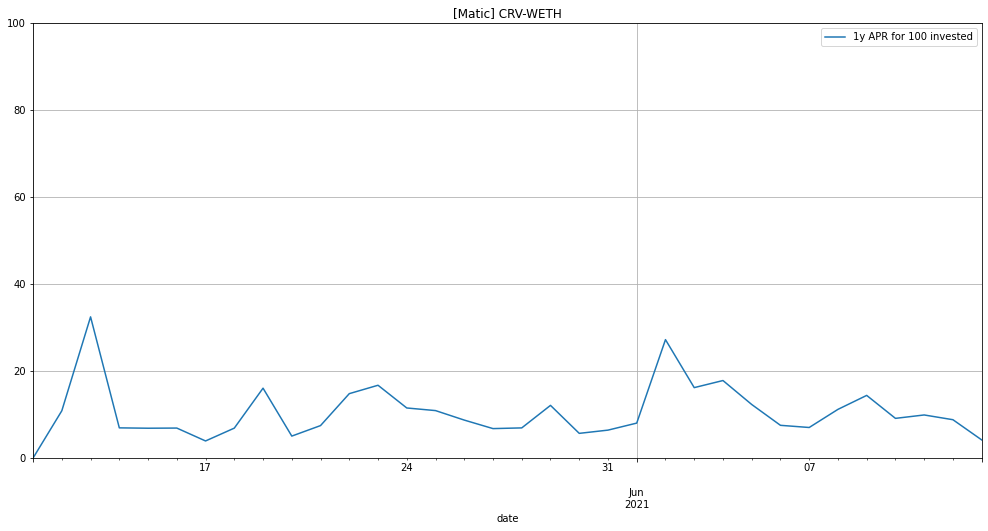

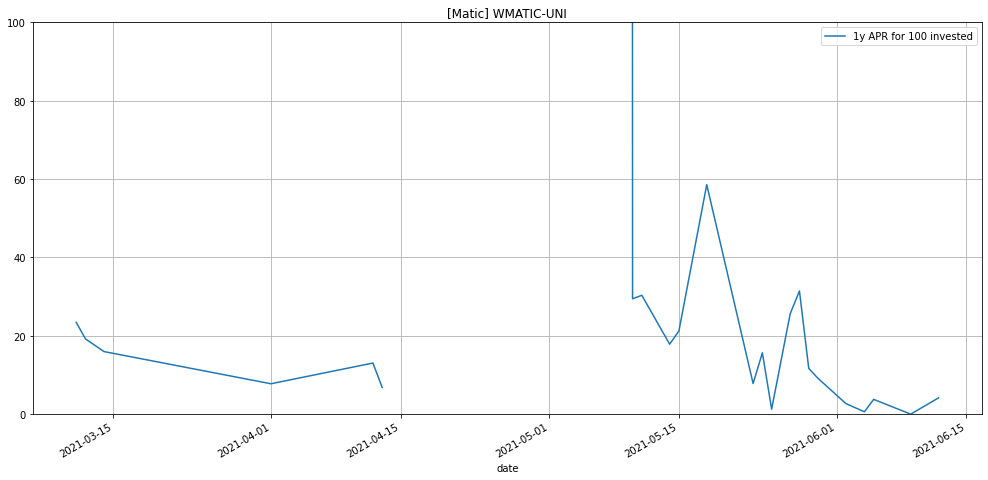

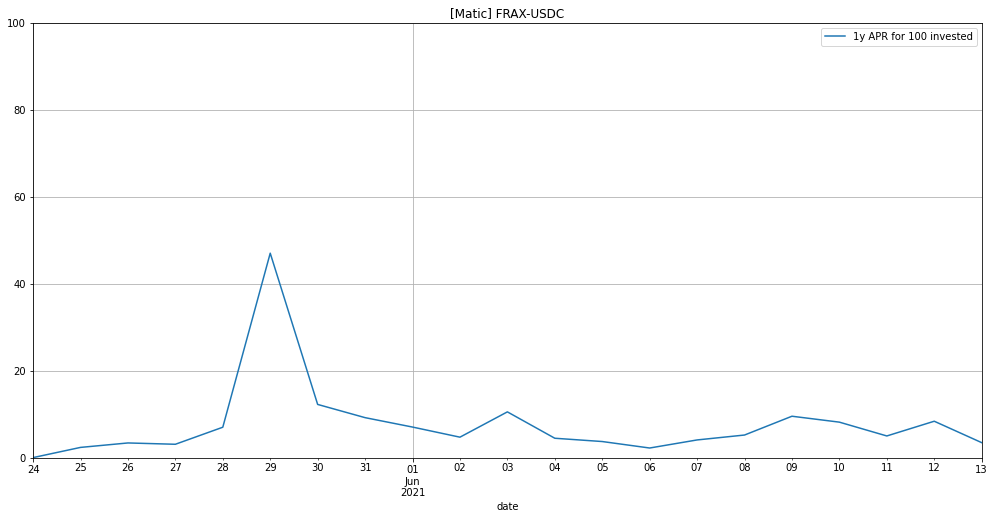

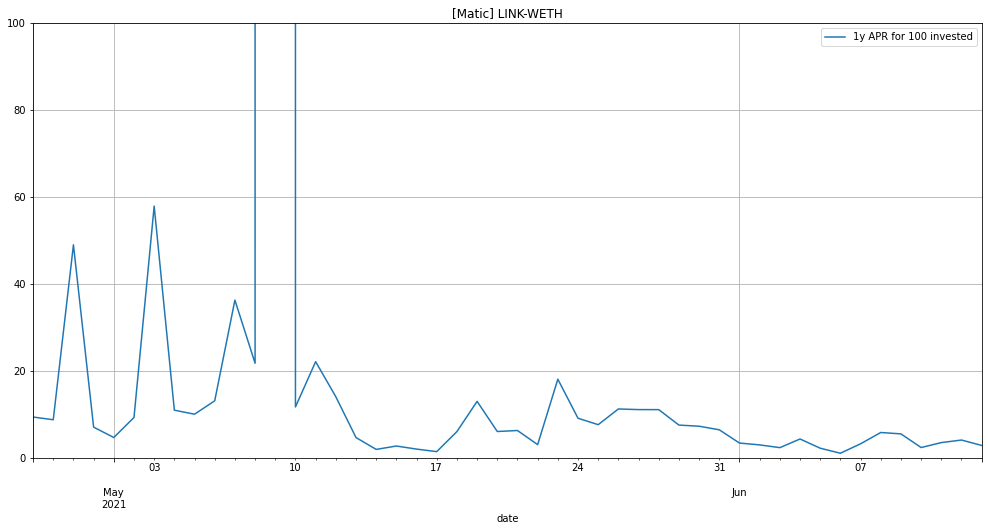

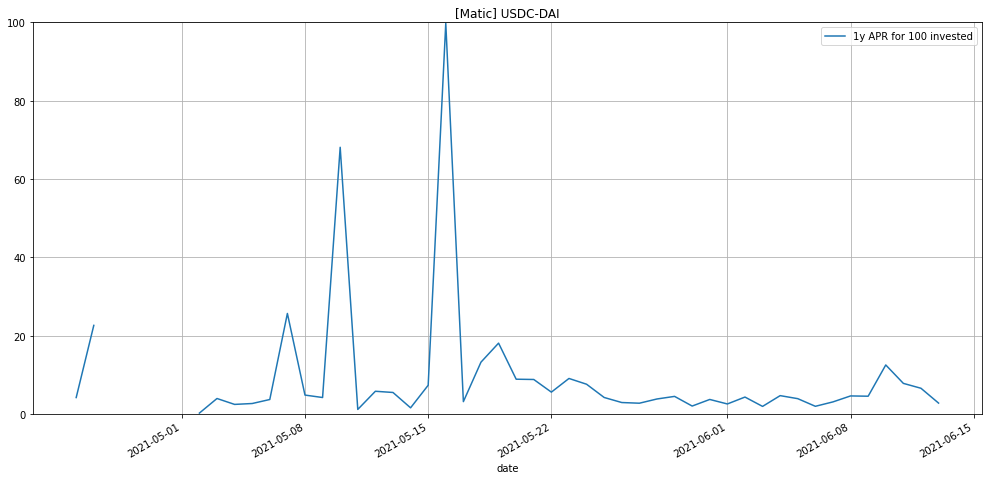

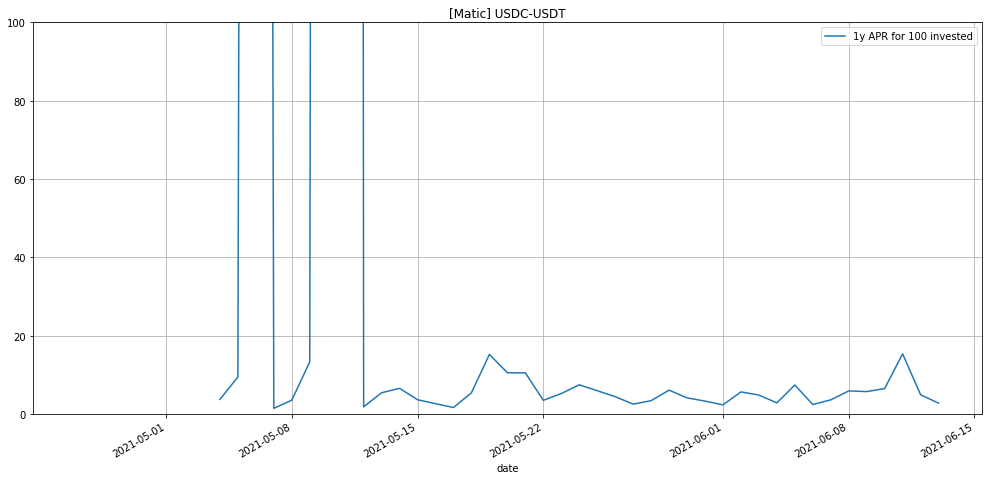

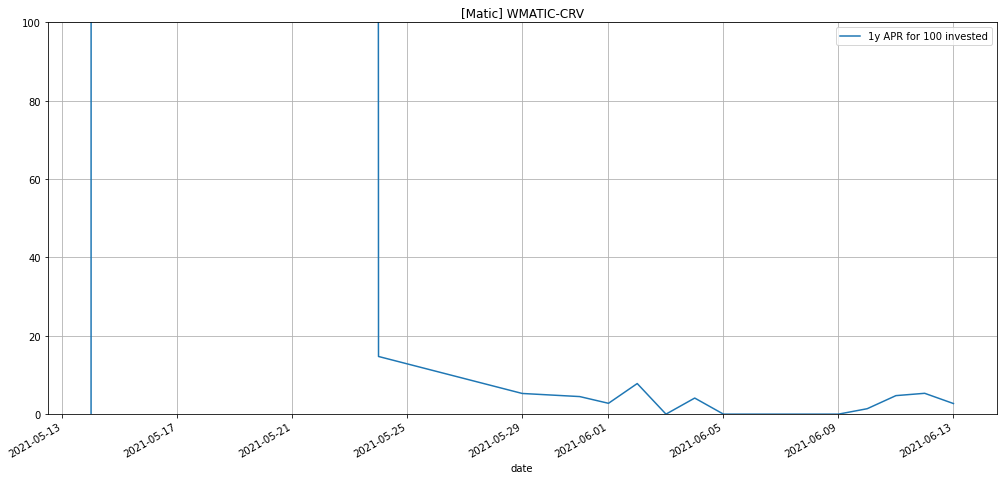

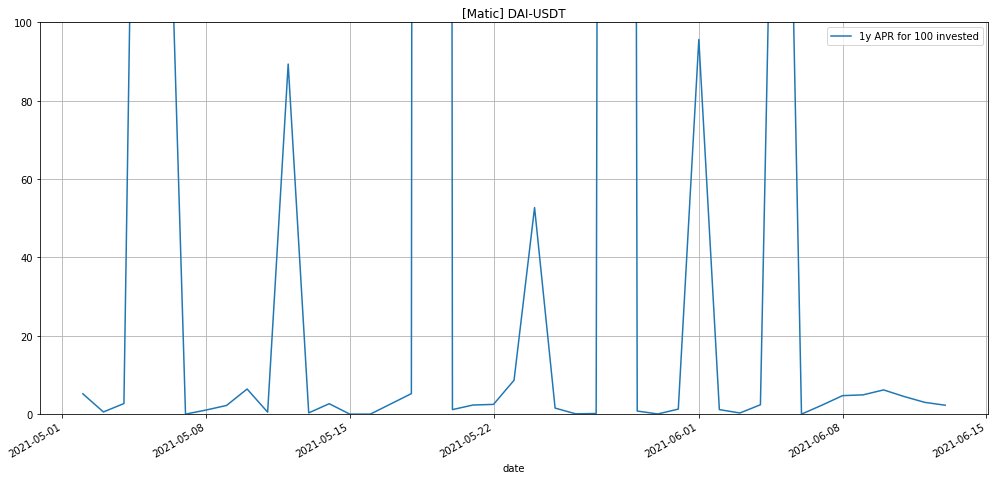

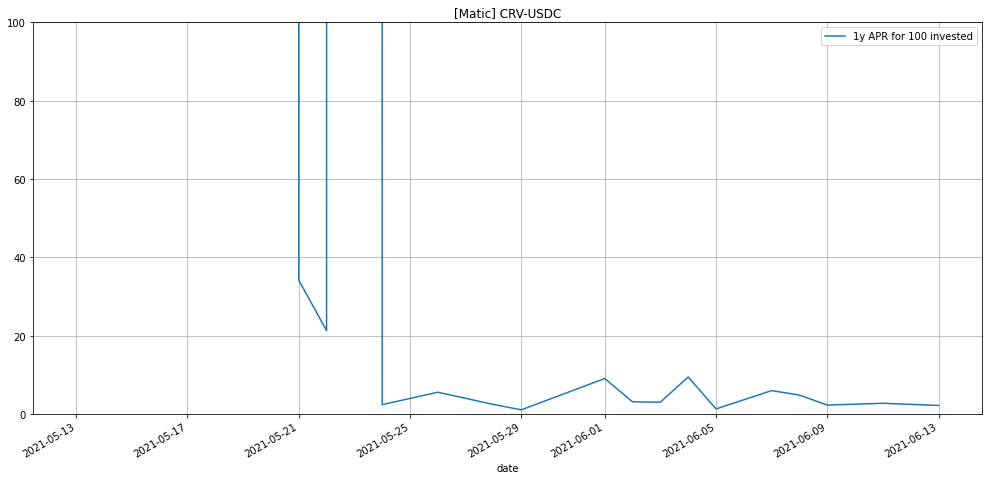

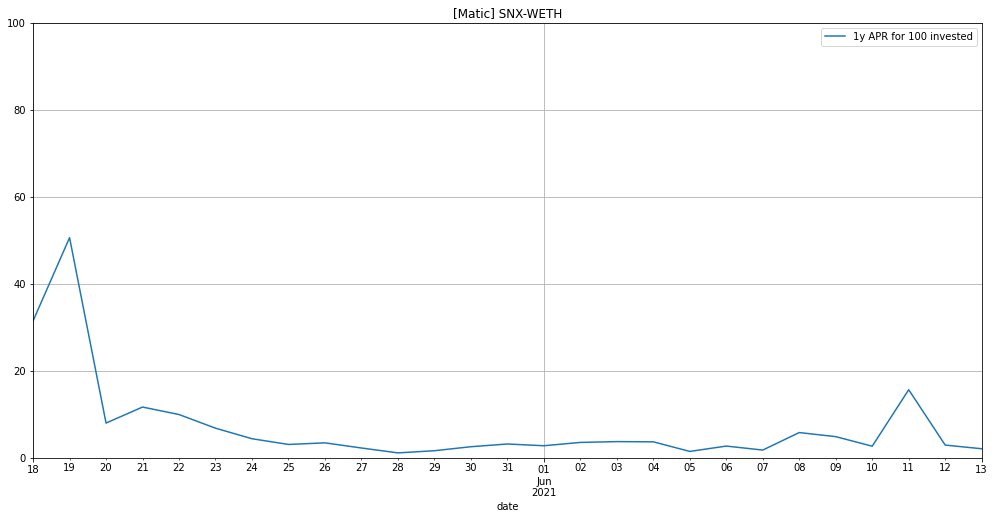

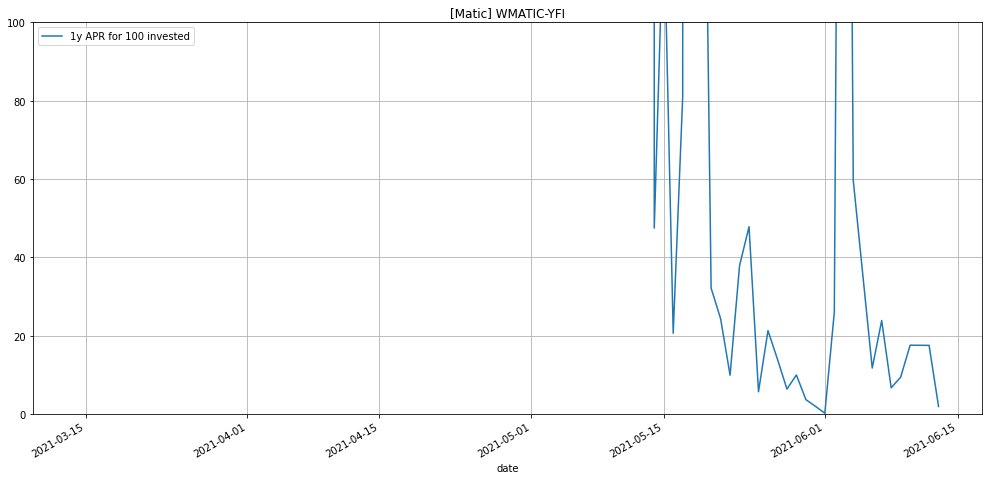

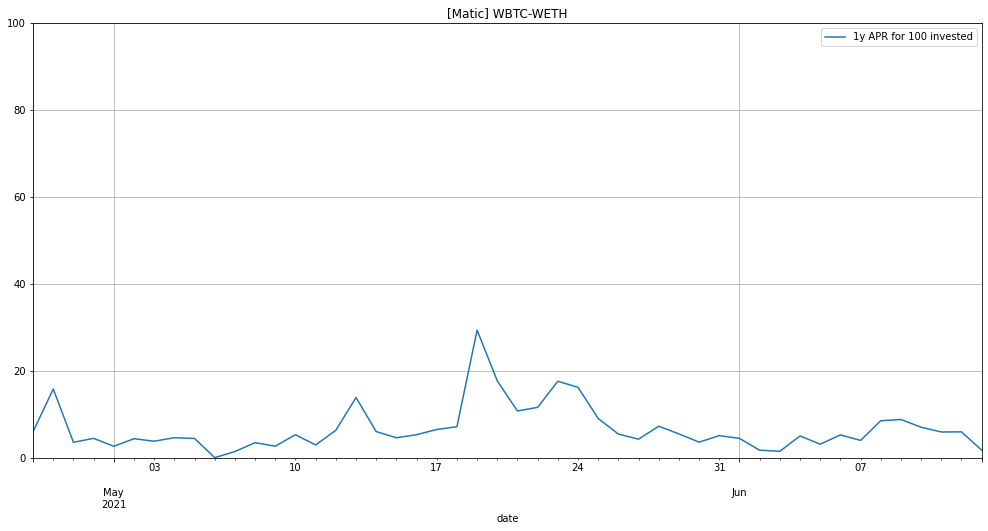

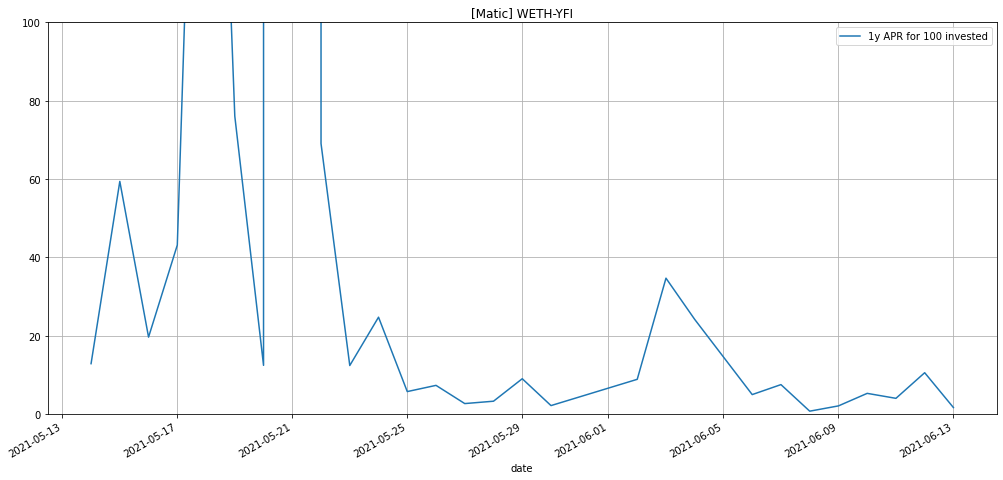

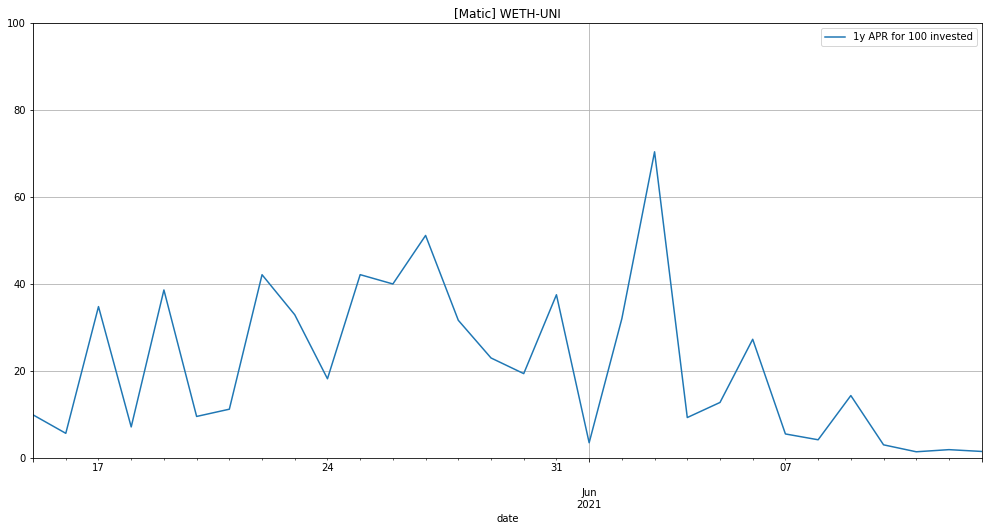

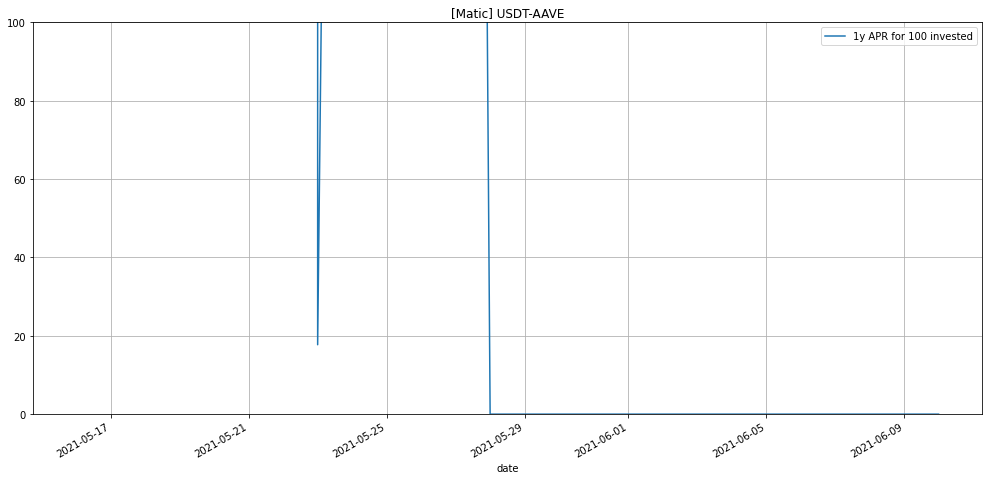

In [93]:
for pair in latest_results['name'].unique():
    criteria = df4.append(df4_fantom)['name'] == pair
    df4.append(df4_fantom).loc[criteria, ['date', '1y APR for 100 invested']].plot(x ='date',
                                                                y='1y APR for 100 invested',
                                                                kind = 'line',
                                                                title = pair,
                                                                figsize = (17,8),
                                                                ylim = (0,100),
                                                                grid = True)

In [ ]:
https://thegraph.com/explorer/subgraph/sushiswap/matic-bentobox